In [32]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy as sp
import requests
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [33]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [34]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [54]:
df_weather = pd.read_csv("external_data.csv")
df_weather['date'] = pd.to_datetime(df_weather.date)
df_weather.drop(df_weather.columns[0], axis=1, inplace=True)
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,holidays2
0,2020-01-09 23:00:00,14.9,NNE,5.6,63,20.0,0,1019.1,21960,48255,5104.0,0
1,2020-01-09 22:00:00,15.2,NNE,5.6,59,20.0,0,1019.0,21960,48255,5104.0,0
2,2020-01-09 21:00:00,16.4,NE,7.4,52,20.0,0,1018.9,21960,48255,5104.0,0
3,2020-01-09 20:00:00,17.1,NNE,7.4,49,20.0,0,1018.5,21960,48255,5104.0,0
4,2020-01-09 19:00:00,18.5,NNE,5.6,46,20.0,0,1017.9,21960,48255,5104.0,0


In [55]:
df_weather.dtypes

date               datetime64[ns]
Temperature (C)           float64
wind_dir                   object
wind_speed                float64
Humidity                    int64
Visibility                float64
Precipitation               int64
pressure1                 float64
sunshine_time               int64
suntime                     int64
new_cases                 float64
holidays2                   int64
dtype: object

In [56]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [57]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


In [58]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [59]:
#COPY THIS CELL
X_train_comb = X_train.join(df_weather.set_index("date"), on="date") 
print(X_train_comb.shape, y_train.shape)
X_train_comb["y_train"] = y_train.copy()
X_train_comb.dropna(inplace=True)
print(X_train_comb.shape)

y_train = X_train_comb["y_train"]
X_train_comb.drop("y_train", axis=1, inplace=True)

#Do the same operations for X_test
X_test_comb = X_test.join(df_weather.set_index("date"), on="date") 
print(X_test_comb.shape)
X_test_comb["y_test"] = y_test.copy()
X_test_comb.dropna(inplace=True)
print(X_test_comb.shape)

y_test = X_test_comb["y_test"]
X_test_comb.drop("y_test", axis=1, inplace=True)
X_test_comb.shape, y_test.shape

(455163, 21) (455163,)
(406351, 22)
(41608, 21)
(41328, 22)


((41328, 21), (41328,))

In [ ]:
X_train.shape, X_train_comb.shape

((455163, 10), (407695, 20))

In [60]:


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)

regressor = Ridge()

pipe0 = make_pipeline(date_encoder, preprocessor, regressor)
pipe0.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001EDB0261870>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

In [61]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe0.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe0.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.73


In [62]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe0.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe0.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.77
Test set, R^2=0.74


We are using Hist Gradient Boosting since our data set is large

In [64]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [65]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
params = {'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None,
              'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0,
              'early_stopping_rounds': None, 'enable_categorical': False, 'eta': 0.3,
              'eval_metric': 'rmse', 'feature_types': None, 'gamma': 0.3, 'gpu_id': -1,
              'grow_policy': 'depthwise', 'importance_type': None,
              'learning_rate': 0.300000012, 'max_bin': 256,
              'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0,
              'max_depth': 12, 'max_leaves': 0, 'min_child_weight': 4,
              'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 0,
              'num_parallel_tree': 1, 'predictor': 'auto', 'tree_method': 'gpu_hist'}

Boost = XGBRegressor(**params)

pipe2 =make_pipeline(date_encoder, preprocessor,Boost)
pipe2.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001EDB0261870>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                              eval_metric='rmse', feature_types=None, gamma=0.3,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=12, max_leaves=0,
                              min_child_weight=4, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=0, num_parallel_tree=1, predictor='auto', ...))])

In [ ]:
pipe2[2].set_params()

GridSearchCV(cv=7,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07, 0.1],
                         'max_depth': [5, 6, 7, 8], 'min_child_weight': [4, 5],
                         'n_estimators': [500, 600], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7], 'tree_method': ['gpu_hist']},
             verbose=True)

In [87]:
import joblib
joblib.dump(pipe2, 'XGB')
joblib.dump(pipe2[2].best_estimator_, 'XGB Best Model')

['XGB Best Model']

In [88]:
joblib.load('XGB Best Model')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', feature_types=None, gamma=0.3, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [21]:
pd.DataFrame(pipe2[2].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree_method,param_subsample,param_objective,param_n_estimators,param_min_child_weight,param_max_depth,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.334073,0.016165,0.000000,0.000000,gpu_hist,0.6,reg:tweedie,500,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,4.664799,0.045896,0.102166,0.010832,gpu_hist,0.9,reg:squarederror,500,4,16,...,-0.591412,-0.533062,-0.530237,-0.583304,-0.488274,-0.348941,-0.535832,-0.515866,0.075386,2
2,3.597081,0.421195,0.154631,0.046642,gpu_hist,0.7,reg:tweedie,300,4,9,...,-0.860892,-0.631952,-0.742555,-0.675453,-0.534456,-0.328038,-0.628080,-0.628775,0.155082,5
3,0.418953,0.029678,0.000000,0.000000,gpu_hist,0.6,reg:tweedie,500,4,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
4,0.592712,0.091479,0.000000,0.000000,gpu_hist,1.0,reg:tweedie,700,4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
5,3.322334,0.251849,0.128315,0.029110,gpu_hist,0.8,reg:squarederror,200,5,9,...,-0.551065,-0.544303,-0.564653,-0.677652,-0.521795,-0.370701,-0.575608,-0.543683,0.084400,3
6,4.107208,0.401711,0.221744,0.052832,gpu_hist,0.6,reg:squarederror,300,4,8,...,-0.610231,-0.501473,-0.593639,-0.632902,-0.529910,-0.386815,-0.567114,-0.546012,0.077436,4
7,2.886757,0.192773,0.117964,0.023097,gpu_hist,0.9,reg:squarederror,200,5,8,...,-0.547766,-0.541309,-0.558798,-0.604275,-0.430392,-0.348369,-0.532351,-0.509037,0.081618,1
8,0.415522,0.007588,0.000000,0.000000,gpu_hist,0.9,reg:tweedie,600,4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
9,0.515135,0.111575,0.000000,0.000000,gpu_hist,0.7,reg:tweedie,300,4,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


<AxesSubplot:>

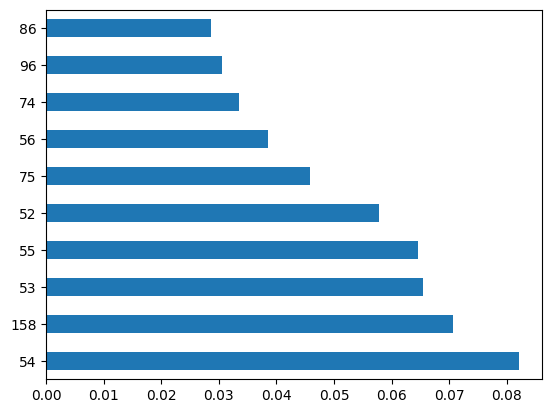

In [47]:
(pd.Series(Boost.feature_importances_)
   .nlargest(10)
   .plot(kind='barh'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

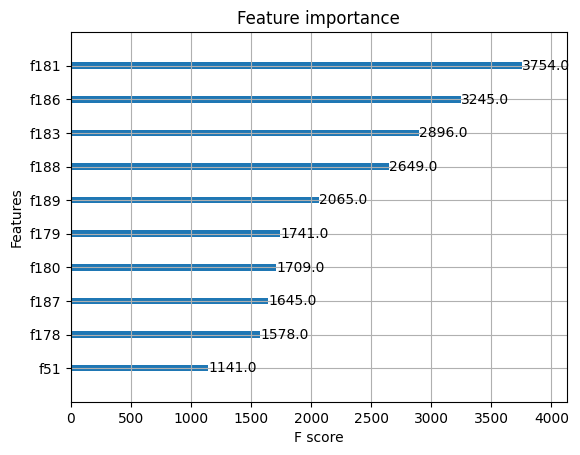

In [66]:
xgb.plot_importance(Boost,max_num_features=10,fmap="")

In [67]:
from sklearn.metrics import mean_squared_error
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe2.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe2.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.32
Test set, RMSE=0.55


In [68]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe2.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe2.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.96
Test set, R^2=0.86


In [69]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe2.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

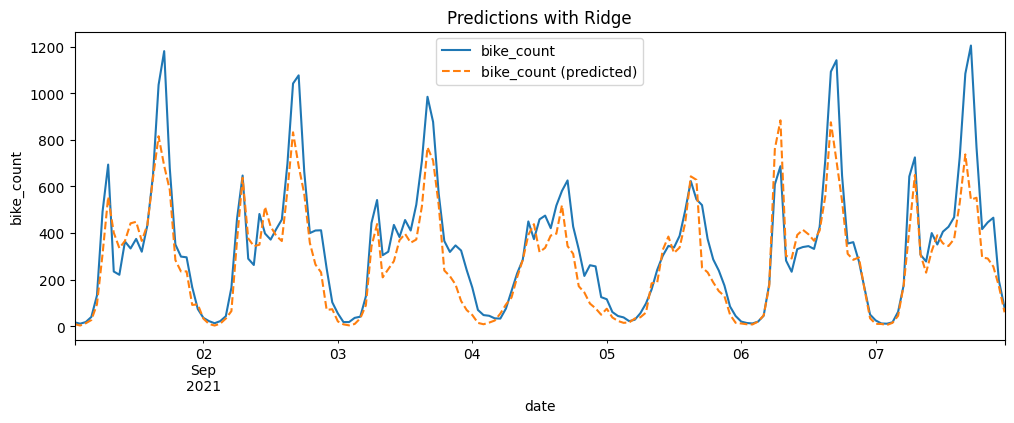

In [70]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

## _LightGBM Regressor_

In [71]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [72]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth':[6,10,15,25,30,35]
    'min_data_in_leaf':[30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

Boost = LGBMRegressor()

pipe3 =make_pipeline(date_encoder, preprocessor, GridSearchCV(Boost,
                        param_grid,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True))
pipe3.fit(X_train_comb, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


KeyboardInterrupt: 

In [87]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe3.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe3.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.36
Test set, RMSE=0.51


In [88]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe3.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe3.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.95
Test set, R^2=0.87


In [138]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe3.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

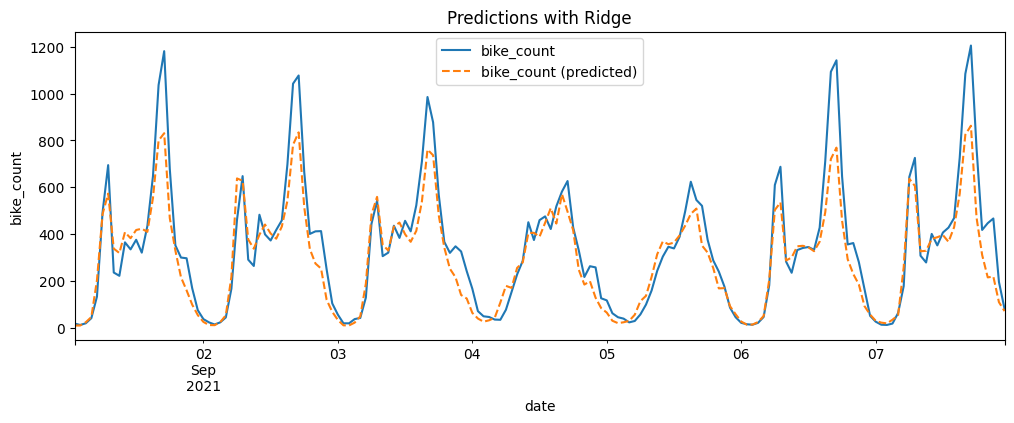

In [139]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

In [140]:
import joblib
joblib.dump(pipe3, 'LGBM')
joblib.dump(pipe3[2].best_estimator_, 'LGBM Best Model')

['LGBM Best Model']

In [1]:
import joblib
joblib.load('LGBM Best Model')

LGBMRegressor(learning_rate:=0.1, max_depth=34, n_estimators=480)

## _CATBoost Regressor_

In [22]:

X_train_comb.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
Temperature (C)                     float64
wind_dir                             object
wind_speed                          float64
Humidity                            float64
Visibility                          float64
Precipitation                       float64
pressure1                           float64
sunshine_time                       float64
suntime                             float64
new_cases                           float64
holidays2                           float64
dtype: object

In [23]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [24]:
X_train_comb.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
Temperature (C)                     float64
wind_dir                             object
wind_speed                          float64
Humidity                            float64
Visibility                          float64
Precipitation                       float64
pressure1                           float64
sunshine_time                       float64
suntime                             float64
new_cases                           float64
holidays2                           float64
dtype: object

In [27]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["year", "month", "day", "weekday", "hour"]
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                      'Humidity', 'Visibility', 'pressure1', "Precipitation", 'sunshine_time', 'suntime', 'new_cases'

preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("scaler", scaler, numerical_cols)
        ]
    )
params = {'ite':[1000,2000],
          'depth':[6,7,8,9,10],
          'max_bin':[None,32,46,100,254],
          'l2_leaf_reg':[None,2,10,20,30],
          'bagging_temperature':[None,0,0.5,1],
          'random_strength':[None,1,5,10],'task_type':['GPU']}

Boost = CatBoostRegressor()

pipeC = make_pipeline(date_encoder, preprocessor, GridSearchCV(Boost,
                        params,
                        cv = 5,
                        n_jobs = 5))

pipeC.fit(X_train_comb, y_train)

ValueError: 
All the 20000 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 2339, in _fit
    train_params = self._prepare_train_params(
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 2266, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6080, in _catboost._check_train_params
  File "_catboost.pyx", line 6099, in _catboost._check_train_params
_catboost.CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/plain_options_helper.cpp:511: Unknown option {ite} with value "1000"

--------------------------------------------------------------------------------
10000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 2339, in _fit
    train_params = self._prepare_train_params(
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 2266, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6080, in _catboost._check_train_params
  File "_catboost.pyx", line 6099, in _catboost._check_train_params
_catboost.CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/plain_options_helper.cpp:511: Unknown option {ite} with value "2000"


In [ ]:
A = pd.DataFrame(pipeC[2].cv_results_)

In [ ]:
A.sort_values("rank_test_score").head(50)

In [30]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipeC.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipeC.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.95
Test set, R^2=0.88


In [31]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipeC.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipeC.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.38
Test set, RMSE=0.49


In [29]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipeC.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

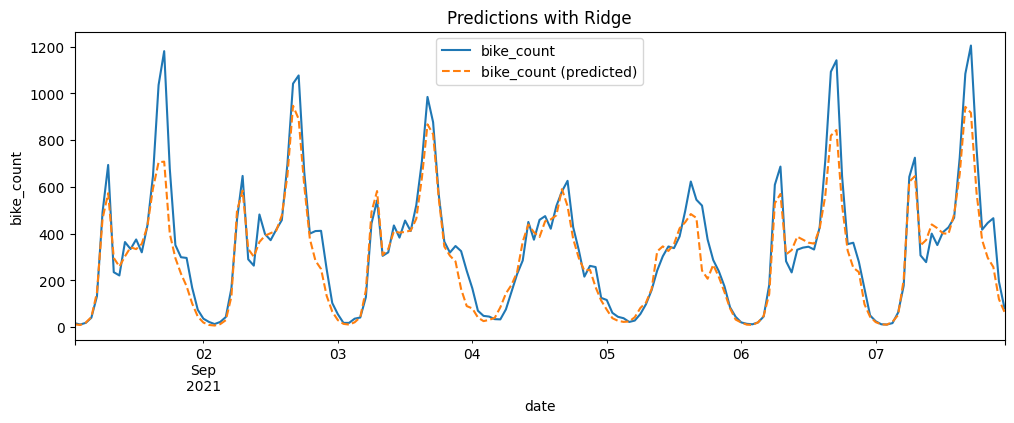

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

In [149]:
import joblib
joblib.dump(pipe3, 'CatBoost')
joblib.dump(pipe3[2].best_estimator_, 'CatBoost Best Model')

['CatBoost Best Model']

## _Random Forest Regressor with GridSearchCV_

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)

RandomForest = RandomForestRegressor(bootstrap=True,oob_score=True)

param_grid = {'max_depth': np.arange(1, 15),
              'n_estimators': np.arange(1, 100, 15),
              'max_features':(.4,.2),
              'min_samples_leaf':(30,20),
              }

pipe4 = make_pipeline(
    date_encoder,
    preprocessor,
    GridSearchCV(RandomForest,
                 param_grid,
                 n_jobs=-1,
                 cv=3)
)
pipe4.fit(X_train_comb, y_train)

In [84]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe4.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe4.predict(X_test_comb)):.2f}"
)

NameError: name 'pipe4' is not defined

In [ ]:
df_result = pd.DataFrame(pipe4[-1].cv_results_)
display(df_result)

In [ ]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe4.predict(X_test_comb[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")